# Where to Live In Warsaw based on public transport connections
### Break greater warsaw into 10k grid units and return public transport journey info where retults are available using Google Maps Directions API

In [4]:
import pandas as pd

#Determine Desired Arrival Time as an integer in seconds since midnight, January 1, 1970 UTC
import time
import datetime

#Create URL string for get request
import urllib.request
import json

## 1: Generate Query Parameters

In [6]:
#Written by: JCA 19/05/2020
#Initial connection with help from: https://www.youtube.com/watch?time_continue=50&v=UrrWxyq1Z48&feature=emb_logo

#Build list of start geos:
#Run a grid of N x N get requests to Google API to check travel times to central Warsaw
#North: 52.07 south to 52.3 (just north of Białołęka) to East: 20.7 to 21 3 (East of Wawer)
#52.2,20.9

N = 52.07 #Most southerly geo coord +0.4
E = 20.8 #Most westerly geo coord +0.5

step_size = 0.5/80 #We want a 80x80 grid grid of 52.07+ 0.5lat and 20.8+0.5 long
n_by_n = 80

x = range(n_by_n) #number of iterations across the coordinates grid (lat and long)
y = range(n_by_n * n_by_n) #total grid size

start_location = []  # initialise list of lists for start locations
start_location_n = []
start_location_e = []
start_location_x = []

for i in y:
    tmp = [str(round(N,5)) + ',' + str(round(E,5))] #iterate across Long(E)
    tmp1 = round(N,5)
    tmp2 = round(E,5)
    start_location.append(tmp)
    start_location_n.append(tmp1)
    start_location_e.append(tmp2)
    tmp3 = [tmp1,tmp2]
    start_location_x.append([tmp3])
    E = E + step_size
    if (i % n_by_n == 0 and i > 0):  #If the remainder/modulus is zero, then move 1 step_size north on the grid
        N = N + step_size
        E = E - (step_size * n_by_n)
    else:
        continue

In [ ]:
#Create the pandas DataFrame  (to output results to CSV), mainly for validation of the logic
start_location_n_df = pd.DataFrame(start_location_n, columns = ['North']) 
start_location_e_df = pd.DataFrame(start_location_e, columns = ['East'])
start_location_df = pd.concat([start_location_n_df, start_location_e_df], axis=1, sort=False)

#Write output to CSV
path = r'C:\Users\jaylward\Desktop\Python Twitter API\Warsaw Google Directions Project'
start_location_df.to_csv(path + '\GoogleDirectionsAPIWarsawCoords.csv', header = ['North','East']) 

In [91]:


# seconds passed since epoch
seconds = time.time()
#We want to arrive at 9am (60*60*24 hours in a day), and leftover tells you today's time
#Get seconds elapsed today. Forget daylight saving time
td = seconds % (60 * 60 * 24)

#Find the weekday
wkd = datetime.date.today().weekday()

#Assume we want to travel next Tuesday (avoid bank holidays). Weekday = 1
extra_days = 7 - (wkd) 
print(extra_days)

#SecondsToday + RemainingSecondsToday + SomeTimeIncrement 
targ_arrival_time = round(seconds + ((60 * 60 * 24) - td) + (60 * 60 * 8) + (extra_days * 24 * 60 * 60))
targ_arrival_dtime = datetime.datetime.fromtimestamp(targ_arrival_time)

#Confirm output
print(targ_arrival_time)
print("Arrival Time:", time.ctime(targ_arrival_time), "UTC")
print(targ_arrival_dtime)

2
1590480000
Arrival Time: Tue May 26 09:00:00 2020 UTC
2020-05-26 09:00:00


In [92]:
#For testing only (a small subset of overall records)
#This is a combination of records which do and do not return routes by mode = transit
start_location_2 = start_location[0:100] + start_location[3150:3250]
start_location_2

[['52.07,20.8'],
 ['52.07,20.80625'],
 ['52.07,20.8125'],
 ['52.07,20.81875'],
 ['52.07,20.825'],
 ['52.07,20.83125'],
 ['52.07,20.8375'],
 ['52.07,20.84375'],
 ['52.07,20.85'],
 ['52.07,20.85625'],
 ['52.07,20.8625'],
 ['52.07,20.86875'],
 ['52.07,20.875'],
 ['52.07,20.88125'],
 ['52.07,20.8875'],
 ['52.07,20.89375'],
 ['52.07,20.9'],
 ['52.07,20.90625'],
 ['52.07,20.9125'],
 ['52.07,20.91875'],
 ['52.07,20.925'],
 ['52.07,20.93125'],
 ['52.07,20.9375'],
 ['52.07,20.94375'],
 ['52.07,20.95'],
 ['52.07,20.95625'],
 ['52.07,20.9625'],
 ['52.07,20.96875'],
 ['52.07,20.975'],
 ['52.07,20.98125'],
 ['52.07,20.9875'],
 ['52.07,20.99375'],
 ['52.07,21.0'],
 ['52.07,21.00625'],
 ['52.07,21.0125'],
 ['52.07,21.01875'],
 ['52.07,21.025'],
 ['52.07,21.03125'],
 ['52.07,21.0375'],
 ['52.07,21.04375'],
 ['52.07,21.05'],
 ['52.07,21.05625'],
 ['52.07,21.0625'],
 ['52.07,21.06875'],
 ['52.07,21.075'],
 ['52.07,21.08125'],
 ['52.07,21.0875'],
 ['52.07,21.09375'],
 ['52.07,21.1'],
 ['52.07,21.10625'],

## 2:Query the API and save raw data as JSON:
#### Prevents unnecessary querying of the API which costs credits/money 

In [108]:

#import API Key
file_object = open(r'C:\Users\jaylward\Desktop\Python Twitter API\API Keys\Google Directions API.txt', 'r') 
api_key = (file_object.read())
endpoint = 'https://maps.googleapis.com/maps/api/directions/json?'
mode = 'transit'  #public transport (defualt is car)

origin = start_location_2 #*********  SWTITCH THIS TO start_location WHEN NOT IN DEBUG MODE!!! ***************
destination = '52.2311639,21.0273170' #Fixed point in central Warsaw
destination_work = '52.18406,21.003141' #Mordor (where lots of offices are located - closer to airport)
directions = [] #initialise list for directions output
zero_results = [] #Add back in at the end as interesting in its own right, but skip all the manipulation
with_results = [] #capture the row_ids (grid numbers) for successulfull queries

#Build query string and call the directions API, capture results in a list
for i in range(len(start_location_2)): #cycle through all locations
    nav_request = 'origin='+start_location_2[i][0]+'&destination='+destination+ '&mode=' + mode + '&arrival_time=' + str(targ_arrival_time) + '&key='+api_key
    request = endpoint + nav_request
    #print(request[0:(len(request)-len(api_key))] + 'my_api_key') #print the url string minus the API Key by slicing out key
    response = urllib.request.urlopen(request).read() #Call the Api and read data out in JSON format
    tmp = json.loads(response) #output JSON results to a large list
    #print(tmp)
    #print(i)
    if tmp['status'] == 'ZERO_RESULTS': #if the results set is empty (no public transit option available) then print out and move on
        #print('loop ' + str(i) + ' no results' )
        zero_results.append([i, start_location_2[i][0], "ZERO RESULTS"])
    else:
        #print ('loop ' + str(i) + ' yes results' )
        directions.append(tmp)
        with_results.append(i)

# ********** SAVE THE RESULTS ********
import json
#Save the raw json results to avoid needing to rerun the query where not necessary
#First convert to a dict
directions_dict = {}
directions_dict['direction'] = []

for i in range(len(directions)):
    directions_dict['direction'].append(directions[i])

#Export the results directionary as json
with open(r'C:\Users\jaylward\Desktop\Python Twitter API\Warsaw Google Directions Project\raw_directions.json', 'w') as outfile:
    json.dump(directions_dict, outfile)

#Convert zero results to a dict
zero_results_dict = {}
zero_results_dict['result'] = []

for i in range(len(zero_results)):
    zero_results_dict['result'].append(zero_results[i])

#Export the zero results directionary as json
with open(r'C:\Users\jaylward\Desktop\Python Twitter API\Warsaw Google Directions Project\zero_results.json', 'w') as outfile:
    json.dump(zero_results_dict, outfile)

In [109]:
#Review outputs
print(len(directions)) #Number of results returned
#print(directions[0:3]) #We are expecting the first few calls not to return a result
print(len(zero_results))
print(zero_results[0:20])
print(len(with_results))
print(with_results[0:20])

181
19
[[1, '52.07,20.80625', 'ZERO RESULTS'], [2, '52.07,20.8125', 'ZERO RESULTS'], [3, '52.07,20.81875', 'ZERO RESULTS'], [66, '52.07,21.2125', 'ZERO RESULTS'], [67, '52.07,21.21875', 'ZERO RESULTS'], [68, '52.07,21.225', 'ZERO RESULTS'], [69, '52.07,21.23125', 'ZERO RESULTS'], [76, '52.07,21.275', 'ZERO RESULTS'], [77, '52.07,21.28125', 'ZERO RESULTS'], [78, '52.07,21.2875', 'ZERO RESULTS'], [79, '52.07,21.29375', 'ZERO RESULTS'], [80, '52.07,21.3', 'ZERO RESULTS'], [141, '52.31375,21.24375', 'ZERO RESULTS'], [142, '52.31375,21.25', 'ZERO RESULTS'], [155, '52.32,20.83125', 'ZERO RESULTS'], [156, '52.32,20.8375', 'ZERO RESULTS'], [157, '52.32,20.84375', 'ZERO RESULTS'], [158, '52.32,20.85', 'ZERO RESULTS'], [159, '52.32,20.85625', 'ZERO RESULTS']]
181
[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


## 3: Access and summarise the journey info we're interested in

In [116]:
# First: reimport the results from JSON:

directions1 = {}
with open(r'C:\Users\jaylward\Desktop\Python Twitter API\Warsaw Google Directions Project\raw_directions.json', "r") as read_file:
    directions1 = json.load(read_file)

zero_results1 = {}
with open(r'C:\Users\jaylward\Desktop\Python Twitter API\Warsaw Google Directions Project\zero_results.json', "r") as read_file:
    zero_results1 = json.load(read_file)

print(directions1.keys())
print(zero_results1.keys())

#reconvert files back to lists to match original output format
directions2 = []
zero_results2 = []



dict_keys(['direction'])
dict_keys(['result'])


In [815]:
#print(directions[10].keys()) #review keys for directions dict

#routes = directions[0]['routes'][0]['legs'] #We're intersted in Routes
#routes[0].keys() #review routes keys
#routes[0]['legs'] #Print legs (journey info)

#We're interested in Legs, within routes
legs = []
for i in range(len(directions)):
    #print(i)
    legs.append(directions[i]['routes'][0]['legs']) #unpack legs from routes from directions into a list of lists

In [826]:
print(len(legs))
#legs[2274][0]

5718


In [886]:
#From Legs, extract the key info we are interested in
duration_mins = []
distance_km = []
departure_time = []
arrival_time = []
start_address = []
end_address = []

#duration_mins = legs[0][0]['duration']['value']
#duration_mins

for j in range(len(legs)):
    duration_mins.append(round((legs[j][0]['duration']['value'])/60,1)) #time quoted in seconds
    distance_km.append((legs[j][0]['distance']['value'])/1000)  #distance quoted in metres
    try:
        departure_time.append(legs[j][0]['departure_time']['value']) #epoch time
    except:
        departure_time.append(1000000000) #Default: some queries don't return departure time (when journey dist v small). Odd!
        #continue
    try:
        arrival_time.append(legs[j][0]['arrival_time']['value']) #epoch time
    except:
         arrival_time.append(1000000000) #Default: some queries don't return departure time (when journey dist v small). Odd!
    try:
        start_address.append(legs[j][0]['start_address'])
    except:
        start_address.append(None)
    try:
        end_address.append(legs[j][0]['end_address'])
    except:
        end_address.append(None)
    
                        
print(duration_mins[0:10])
print(distance_km[0:10])
print(departure_time[0:10])
print(arrival_time[0:10])
print(start_address[0:10])
print(end_address[0:10])

[134.1, 130.0, 127.6, 125.0, 108.5, 97.0, 98.8, 86.5, 85.1, 90.6]
[48.799, 48.471, 48.258, 49.605, 32.557, 31.612, 31.75, 30.733, 30.615, 31.075]
[1590469564, 1590469810, 1590469954, 1590470108, 1590471103, 1590471791, 1590471683, 1590472422, 1590472506, 1590472175]
[1590477610, 1590477610, 1590477610, 1590477610, 1590477610, 1590477610, 1590477610, 1590477610, 1590477610, 1590477610]
['aleja Olszowa 3, 05-825 Książenice, Poland', 'Promyka 164, 05-830 Urzut, Poland', 'Promyka 30, 05-830 Urzut, Poland', 'Malownicza 34, 05-830 Urzut, Poland', 'Aleja Katowicka 360, 05-830 Urzut, Poland', 'Aleja Katowicka 239, 05-830 Urzut, Poland', 'Jesienna 16, 05-830 Urzut, Poland', 'Unnamed Road, 05-830, Poland', 'Aleja Kasztanowa 159, 05-831 Młochów, Poland', 'Aleja Kasztanowa 160, 05-831 Młochów, Poland']
['aleja Obertyńskiej 1, 00-498 Warszawa, Poland', 'aleja Obertyńskiej 1, 00-498 Warszawa, Poland', 'aleja Obertyńskiej 1, 00-498 Warszawa, Poland', 'aleja Obertyńskiej 1, 00-498 Warszawa, Poland', '

In [887]:
#For each leg, how many steps (sections) are there? How long are they, and what form of transport?
#Initialise list to store individual sections of journies in list of lists
legs_sections = [] #journey parts/steps/sections
legs_summary = [] #output of this step for further aggregation

for k in range(len(legs)):
    legs_sections.append(legs[k][0]['steps'])

tmp = []

#Then unpack distance, duration and travel type for each step/section
for journey in range(len(legs_sections)): #journey is integer counter
    #print("journey counter = " + str(journey))
    for step in range (len(legs_sections[journey])): #step is integer counter
        #print("step counter = " + str(step))
        #print(legs_sections[journey][step]['travel_mode'])
        #print((legs_sections[journey][step]['distance']['value'])/1000)
        #print((legs_sections[journey][step]['duration']['value'])/60)
        tmp.append([journey, step, legs_sections[journey][step]['travel_mode'],
                       round((legs_sections[journey][step]['distance']['value']/1000),2),
                       round((legs_sections[journey][step]['duration']['value']/60),2)])
    legs_summary.append(tmp)
    tmp = [] #reset temp otherwise you append everything to everything before it, just want output of inner loop
    
#Check outputs
legs_summary[0:3] 

[[[0, 0, 'WALKING', 1.76, 21.93],
  [0, 1, 'TRANSIT', 4.16, 8.0],
  [0, 2, 'TRANSIT', 33.56, 53.0],
  [0, 3, 'WALKING', 0.23, 2.87],
  [0, 4, 'TRANSIT', 8.43, 32.0],
  [0, 5, 'WALKING', 0.65, 8.17]],
 [[1, 0, 'WALKING', 1.43, 17.83],
  [1, 1, 'TRANSIT', 4.16, 8.0],
  [1, 2, 'TRANSIT', 33.56, 53.0],
  [1, 3, 'WALKING', 0.23, 2.87],
  [1, 4, 'TRANSIT', 8.43, 32.0],
  [1, 5, 'WALKING', 0.65, 8.17]],
 [[2, 0, 'WALKING', 1.22, 15.42],
  [2, 1, 'TRANSIT', 4.16, 8.0],
  [2, 2, 'TRANSIT', 33.56, 53.0],
  [2, 3, 'WALKING', 0.23, 2.87],
  [2, 4, 'TRANSIT', 8.43, 32.0],
  [2, 5, 'WALKING', 0.65, 8.17]]]

In [888]:
#Aggregate legs summary data to % walking vs %transit vs total time
walking_time = []
walking_dist = []
tmp1 = []
tmp2 = []

for journey in range(len(legs_summary)):
    for step in range(len(legs_summary[journey])):
        if legs_summary[journey][step][2] == 'WALKING':
            tmp1.append([journey,step,legs_summary[journey][step][3]])  ##distance
            tmp2.append([journey,step,legs_summary[journey][step][4]]) ##time
        else:
            continue
    walking_dist.append(tmp1)
    walking_time.append(tmp2)
    tmp1 = []
    tmp2 = []

# Review output data
print(walking_dist[0:3])
print(walking_time[0:3])

[[[0, 0, 1.76], [0, 3, 0.23], [0, 5, 0.65]], [[1, 0, 1.43], [1, 3, 0.23], [1, 5, 0.65]], [[2, 0, 1.22], [2, 3, 0.23], [2, 5, 0.65]]]
[[[0, 0, 21.93], [0, 3, 2.87], [0, 5, 8.17]], [[1, 0, 17.83], [1, 3, 2.87], [1, 5, 8.17]], [[2, 0, 15.42], [2, 3, 2.87], [2, 5, 8.17]]]


In [889]:
#Sum up walking % of total both distance and time-wise
walking_dist_pc = []
walking_time_pc = []
tmp1 = []
tmp2 = []

# [journey number], [step number], [2] = value from list we want
#walking_dist[journey][step][2]

for journey in range(len(walking_dist)):
    #print(journey)
    for step in range(len(walking_dist[journey])):
        #print(step)
        #print(walking_dist[journey][step][2])
        tmp1.append(walking_dist[journey][step][2])
        tmp2.append(walking_time[journey][step][2])
    walking_dist_pc.append(tmp1)
    walking_time_pc.append(tmp2)
    tmp1 = []
    tmp2 = []

#initialise final output lists for walking by distance and time as % of respective totals
walking_dist_pc2 = []
walking_time_pc2 = []


for i in range(len(walking_dist_pc)):
    walking_dist_pc2.append((round(sum(walking_dist_pc[i]) / distance_km[i],3)))
    walking_time_pc2.append((round(sum(walking_time_pc[i]) / duration_mins[i],3)))

#Check outputs (1 list item = 1 journey)
print(walking_dist_pc2[0:5])
print(walking_time_pc2[0:5])

[0.054, 0.048, 0.044, 0.034, 0.101]
[0.246, 0.222, 0.207, 0.167, 0.372]


In [895]:
#Putting it all together as a summary list
#Then output to a DataFrame
journey_summary = []

#origin[journey][constant]. Destination is a constant
for journey in range(len(walking_time_pc2)): #Any field will do here (expect origin if debugging)
    tmp = [origin[journey][0], destination, targ_arrival_dtime, 
           datetime.datetime.fromtimestamp(departure_time[journey]), datetime.datetime.fromtimestamp(arrival_time[journey]), 
           start_address[journey], end_address[journey], duration_mins[journey], distance_km[journey], 
            len(legs_summary[journey]), round(sum(walking_time_pc[journey]),3), round(sum(walking_dist_pc[journey]),3), 
            walking_time_pc2[journey], walking_dist_pc2[journey],
           datetime.datetime.fromtimestamp(seconds), datetime.datetime.fromtimestamp(time.time())]
    journey_summary.append(tmp)
    tmp = []

journey_summary_df = pd.DataFrame(journey_summary, columns = ['Origin','Destination', 'TargArrivalDTime',
        'DepartureTime', 'ArrivalTime', 'StartAddress', 'EndAddress', 'DurationMins','DistanceKm','Sections',
        'WalkingTime','WalkingDistance','WalkingTimePc','WalkingDistPc','ScriptStartTime','FileOutputDTime']) #, columns = ['Origin'])
#Insert query_ids for successfull runs
#Join in the list's values rather than the list itself
journey_summary_df.insert(0,'QueryId',[with_results][0])

# Unsuccessfull data to a dataframe (drop the "no results" string which we don't want)
zero_results_df = pd.DataFrame(zero_results,columns = ['QueryId','Origin','Destination']).replace('ZERO RESULTS',destination)

#Append queries for locations with no results using concat
journey_summary_final_df = pd.concat([journey_summary_df, zero_results_df],sort = False)

#Export to DF to CSV: Nulls = 'NULL'
journey_summary_final_df.to_csv(path + '\GoogleDirectionsAPIWarsawResults.csv', na_rep = 'NULL',) 

#Review DataFrame with both successfull and unsuccessfull queries
print(journey_summary_final_df.info()) #Success!
journey_summary_final_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 4281
Data columns (total 17 columns):
QueryId             10000 non-null int64
Origin              10000 non-null object
Destination         10000 non-null object
TargArrivalDTime    5718 non-null datetime64[ns]
DepartureTime       5718 non-null datetime64[ns]
ArrivalTime         5718 non-null datetime64[ns]
StartAddress        5718 non-null object
EndAddress          5718 non-null object
DurationMins        5718 non-null float64
DistanceKm          5718 non-null float64
Sections            5718 non-null float64
WalkingTime         5718 non-null float64
WalkingDistance     5718 non-null float64
WalkingTimePc       5718 non-null float64
WalkingDistPc       5718 non-null float64
ScriptStartTime     5718 non-null datetime64[ns]
FileOutputDTime     5718 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(7), int64(1), object(4)
memory usage: 1.4+ MB
None


QueryId        Origin            Destination    TargArrivalDTime  \
0         5    52.07,20.7  52.2311639,21.0273170 2020-05-26 09:00:00   
1         6  52.07,20.706  52.2311639,21.0273170 2020-05-26 09:00:00   
2         7  52.07,20.712  52.2311639,21.0273170 2020-05-26 09:00:00   
3         8  52.07,20.718  52.2311639,21.0273170 2020-05-26 09:00:00   
4         9  52.07,20.724  52.2311639,21.0273170 2020-05-26 09:00:00   
5        10   52.07,20.73  52.2311639,21.0273170 2020-05-26 09:00:00   
6        11  52.07,20.736  52.2311639,21.0273170 2020-05-26 09:00:00   
7        12  52.07,20.742  52.2311639,21.0273170 2020-05-26 09:00:00   
8        13  52.07,20.748  52.2311639,21.0273170 2020-05-26 09:00:00   
9        14  52.07,20.754  52.2311639,21.0273170 2020-05-26 09:00:00   
10       15   52.07,20.76  52.2311639,21.0273170 2020-05-26 09:00:00   
11       16  52.07,20.766  52.2311639,21.0273170 2020-05-26 09:00:00   
12       17  52.07,20.772  52.2311639,21.0273170 2020-05-26 09:00:00   
13       20  52.07,20.778  52.2311639,21.0273170 2020-05-26 09:00:00   
14       21  52.07,20.784  52.2311639,21.0273170 2020-05-26 09:00:00   
15       22   52.07,20.79  52.2311639,21.0273170 2020-05-26 09:00:00   
16       23  52.07,20.796  52.2311639,21.0273170 2020-05-26 09:00:00   
17       24  52.07,20.802  52.2311639,21.0273170 2020-05-26 09:00:00   
18       25  52.07,20.808  52.2311639,21.0273170 2020-05-26 09:00:00   
19       26  52.07,20.814  52.2311639,21.0273170 2020-05-26 09:00:00   

         DepartureTime         ArrivalTime  \
0  2020-05-26 06:06:04 2020-05-26 08:20:10   
1  2020-05-26 06:10:10 2020-05-26 08:20:10   
2  2020-05-26 06:12:34 2020-05-26 08:20:10   
3  2020-05-26 06:15:08 2020-05-26 08:20:10   
4  2020-05-26 06:31:43 2020-05-26 08:20:10   
5  2020-05-26 06:43:11 2020-05-26 08:20:10   
6  2020-05-26 06:41:23 2020-05-26 08:20:10   
7  2020-05-26 06:53:42 2020-05-26 08:20:10   
8  2020-05-26 06:55:06 2020-05-26 08:20:10   
9  2020-05-26 06:49:35 2020-05-26 08:20:10   
10 2020-05-26 06:45:04 2020-05-26 08:20:10   
11 2020-05-26 06:40:06 2020-05-26 08:20:10   
12 2020-05-26 06:36:14 2020-05-26 08:20:10   
13 2020-05-26 06:08:34 2020-05-26 08:01:10   
14 2020-05-26 06:15:10 2020-05-26 08:01:10   
15 2020-05-26 06:16:52 2020-05-26 08:01:10   
16 2020-05-26 06:17:12 2020-05-26 08:01:10   
17 2020-05-26 06:54:46 2020-05-26 08:36:10   
18 2020-05-26 06:54:48 2020-05-26 08:36:10   
19 2020-05-26 07:12:09 2020-05-26 08:56:50   

                                    StartAddress  \
0     aleja Olszowa 3, 05-825 Książenice, Poland   
1              Promyka 164, 05-830 Urzut, Poland   
2               Promyka 30, 05-830 Urzut, Poland   
3            Malownicza 34, 05-830 Urzut, Poland   
4      Aleja Katowicka 360, 05-830 Urzut, Poland   
5      Aleja Katowicka 239, 05-830 Urzut, Poland   
6              Jesienna 16, 05-830 Urzut, Poland   
7                   Unnamed Road, 05-830, Poland   
8   Aleja Kasztanowa 159, 05-831 Młochów, Poland   
9   Aleja Kasztanowa 160, 05-831 Młochów, Poland   
10            Cytrynowa 3, 05-830 Rusiec, Poland   
11                Cicha 4, 05-830 Rusiec, Poland   
12              Główna 99, 05-830 Rusiec, Poland   
13       Czarny Las 129, 05-830 Kajetany, Poland   
14           Klonowa 25, 05-830 Kajetany, Poland   
15        Czarny Las 63, 05-830 Kajetany, Poland   
16        Nadarzyńska 41, 05-830 Szamoty, Poland   
17        Nadarzyńska 51, 05-830 Szamoty, Poland   
18          Wschodnia 17, 05-830 Szamoty, Poland   
19        Karmazynowa 17, 05-552 Marysin, Poland   

                                       EndAddress  DurationMins  DistanceKm  \
0   aleja Obertyńskiej 1, 00-498 Warszawa, Poland         134.1      48.799   
1   aleja Obertyńskiej 1, 00-498 Warszawa, Poland         130.0      48.471   
2   aleja Obertyńskiej 1, 00-498 Warszawa, Poland         127.6      48.258   
3   aleja Obertyńskiej 1, 00-498 Warszawa, Poland         125.0      49.605   
4   aleja Obertyńskiej 1, 00-498 War

## 4: Analyse the results!
### We're interested in locations with not more than 40 mins travel time door to door

In [59]:
#Import the data from CSV to avoid rerunning API which costs and takes time
import pandas as pd

journies = pd.read_csv(r'C:\Users\jaylward\Desktop\Python Twitter API\Warsaw Google Directions Project\GoogleDirectionsAPIWarsawResults.csv')
journies.head()

Unnamed: 0  QueryId        Origin            Destination  \
0           0        5    52.07,20.7  52.2311639,21.0273170   
1           1        6  52.07,20.706  52.2311639,21.0273170   
2           2        7  52.07,20.712  52.2311639,21.0273170   
3           3        8  52.07,20.718  52.2311639,21.0273170   
4           4        9  52.07,20.724  52.2311639,21.0273170   

      TargArrivalDTime        DepartureTime          ArrivalTime  \
0  2020-05-26 09:00:00  2020-05-26 06:06:04  2020-05-26 08:20:10   
1  2020-05-26 09:00:00  2020-05-26 06:10:10  2020-05-26 08:20:10   
2  2020-05-26 09:00:00  2020-05-26 06:12:34  2020-05-26 08:20:10   
3  2020-05-26 09:00:00  2020-05-26 06:15:08  2020-05-26 08:20:10   
4  2020-05-26 09:00:00  2020-05-26 06:31:43  2020-05-26 08:20:10   

                                 StartAddress  \
0  aleja Olszowa 3, 05-825 Książenice, Poland   
1           Promyka 164, 05-830 Urzut, Poland   
2            Promyka 30, 05-830 Urzut, Poland   
3         Malownicza 34, 05-830 Urzut, Poland   
4   Aleja Katowicka 360, 05-830 Urzut, Poland   

                                      EndAddress  DurationMins  DistanceKm  \
0  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         134.1      48.799   
1  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         130.0      48.471   
2  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         127.6      48.258   
3  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         125.0      49.605   
4  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         108.5      32.557   

   Sections  WalkingTime  WalkingDistance  WalkingTimePc  WalkingDistPc  \
0       6.0        32.97             2.64          0.246          0.054   
1       6.0        28.87             2.31          0.222          0.048   
2       6.0        26.46             2.10          0.207          0.044   
3       6.0        20.87             1.71          0.167          0.034   
4       5.0        40.32             3.29          0.372          0.101   

              ScriptStartTime             FileOutputDTime  
0  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349  
1  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349  
2  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349  
3  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349  
4  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349

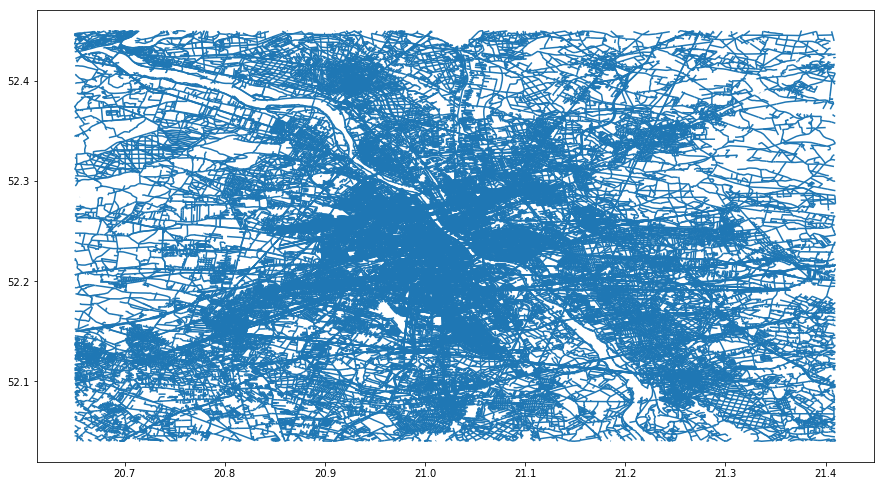

In [56]:
#Plot the outputs 
#following blog https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

#Read in shape file using Geopandas
#Shapefile from https://download.bbbike.org/osm/bbbike/Warsaw/
warsaw = gpd.read_file(r'C:\Users\jaylward\Desktop\Python Twitter API\Warsaw Google Directions Project\WarsawShapeFile\Warsaw-shp\shape\roads.shp')

fig,ax = plt.subplots(figsize = (15,15))
warsaw.plot(ax = ax)

In [60]:
#Convert data to correct format in preparation for geoframe and points

#Split the origin coords into lat and long (easier to work with)
origins = journies['Origin'].str.split(pat = ",", expand=True)
origins.columns= ['OriginLat','OriginLong']
journies = pd.concat([journies, origins], axis=1, sort=False)
journies['OriginLat'] = journies['OriginLat'].astype(float)
journies['OriginLong'] = journies['OriginLong'].astype(float)

print(journies.head(10))
journies.info()

   Unnamed: 0  QueryId        Origin            Destination  \
0           0        5    52.07,20.7  52.2311639,21.0273170   
1           1        6  52.07,20.706  52.2311639,21.0273170   
2           2        7  52.07,20.712  52.2311639,21.0273170   
3           3        8  52.07,20.718  52.2311639,21.0273170   
4           4        9  52.07,20.724  52.2311639,21.0273170   
5           5       10   52.07,20.73  52.2311639,21.0273170   
6           6       11  52.07,20.736  52.2311639,21.0273170   
7           7       12  52.07,20.742  52.2311639,21.0273170   
8           8       13  52.07,20.748  52.2311639,21.0273170   
9           9       14  52.07,20.754  52.2311639,21.0273170   

      TargArrivalDTime        DepartureTime          ArrivalTime  \
0  2020-05-26 09:00:00  2020-05-26 06:06:04  2020-05-26 08:20:10   
1  2020-05-26 09:00:00  2020-05-26 06:10:10  2020-05-26 08:20:10   
2  2020-05-26 09:00:00  2020-05-26 06:12:34  2020-05-26 08:20:10   
3  2020-05-26 09:00:00  2020-05-26

In [61]:
#Convert Lat and Long to Point Objects
geometry = [Point(xy) for xy in zip(journies['OriginLong'],journies['OriginLat'])]

crs = {'init':'espg:4326'}

#Create GeoPandas GeoDataFrame!
geo_df = gpd.GeoDataFrame(journies,
                          crs = crs, #Coordinate references system...
                          geometry = geometry) #Points from above

geo_df.head(5)

Unnamed: 0  QueryId        Origin            Destination  \
0           0        5    52.07,20.7  52.2311639,21.0273170   
1           1        6  52.07,20.706  52.2311639,21.0273170   
2           2        7  52.07,20.712  52.2311639,21.0273170   
3           3        8  52.07,20.718  52.2311639,21.0273170   
4           4        9  52.07,20.724  52.2311639,21.0273170   

      TargArrivalDTime        DepartureTime          ArrivalTime  \
0  2020-05-26 09:00:00  2020-05-26 06:06:04  2020-05-26 08:20:10   
1  2020-05-26 09:00:00  2020-05-26 06:10:10  2020-05-26 08:20:10   
2  2020-05-26 09:00:00  2020-05-26 06:12:34  2020-05-26 08:20:10   
3  2020-05-26 09:00:00  2020-05-26 06:15:08  2020-05-26 08:20:10   
4  2020-05-26 09:00:00  2020-05-26 06:31:43  2020-05-26 08:20:10   

                                 StartAddress  \
0  aleja Olszowa 3, 05-825 Książenice, Poland   
1           Promyka 164, 05-830 Urzut, Poland   
2            Promyka 30, 05-830 Urzut, Poland   
3         Malownicza 34, 05-830 Urzut, Poland   
4   Aleja Katowicka 360, 05-830 Urzut, Poland   

                                      EndAddress  DurationMins  ...  Sections  \
0  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         134.1  ...       6.0   
1  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         130.0  ...       6.0   
2  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         127.6  ...       6.0   
3  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         125.0  ...       6.0   
4  aleja Obertyńskiej 1, 00-498 Warszawa, Poland         108.5  ...       5.0   

   WalkingTime  WalkingDistance  WalkingTimePc  WalkingDistPc  \
0        32.97             2.64          0.246          0.054   
1        28.87             2.31          0.222          0.048   
2        26.46             2.10          0.207          0.044   
3        20.87             1.71          0.167          0.034   
4        40.32             3.29          0.372          0.101   

              ScriptStartTime             FileOutputDTime OriginLat  \
0  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349     52.07   
1  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349     52.07   
2  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349     52.07   
3  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349     52.07   
4  2020-05-23 09:23:18.923349  2020-05-23 11:13:08.151349     52.07   

   OriginLong                   geometry  
0      20.700  POINT (20.70000 52.07000)  
1      20.706  POINT (20.70600 52.07000)  
2      20.712  POINT (20.71200 52.07000)  
3      20.718  POINT (20.71800 52.07000)  
4      20.724  POINT (20.72400 52.07000)  

[5 rows x 21 columns]

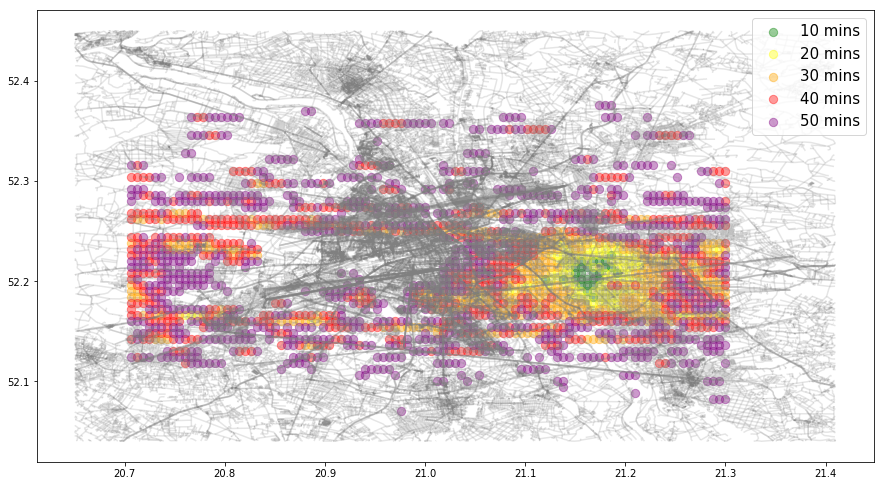

In [86]:
#Plot again, but superimpose points on the map using matplotlib.pyplot
#Round duration times to -1, i.e. remove 1 significant figure to nearest 10 mins
fig,ax = plt.subplots(figsize = (15,15))
warsaw.plot(ax = ax, alpha = 0.2, color = 'grey')
geo_df[round(geo_df['DurationMins'],-1) == 10].plot(ax=ax, alpha=0.4, markersize = 70,color = 'green',marker = 'o',label = '10 mins')
geo_df[round(geo_df['DurationMins'],-1) == 20].plot(ax=ax, alpha=0.4, markersize = 70,color = 'yellow',marker = 'o',label = '20 mins')
geo_df[round(geo_df['DurationMins'],-1) == 30].plot(ax=ax, alpha=0.4, markersize = 70,color = 'orange',marker = 'o',label = '30 mins')
geo_df[round(geo_df['DurationMins'],-1) == 40].plot(ax=ax, alpha=0.4, markersize = 70,color = 'red',marker = 'o',label = '40 mins')
geo_df[round(geo_df['DurationMins'],-1) == 50].plot(ax=ax, alpha=0.4, markersize = 70,color = 'purple',marker = 'o',label = '50 mins')
#geo_df[round(geo_df['DurationMins'],-1) >= 55].plot(ax=ax, markersize = 20,color = 'grey',marker = 'o',label = '>55 mins')
plt.legend(prop={'size':15})
